# In this project I will apply a mesh of 1D convolution layer with bidirectional LSTM to predict a synthetic time series

### Import the libraries and define the utility functions

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [19]:
# Define the series plotting function
def plot_series(time, series, format="-", start=0, end=None):

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

# Define the trend line
def trend(time, slope=0):

    # Compute the linear series given the slope
    series = slope * time

    return series

# Define a random seasonal pattern
def seasonal_pattern(season_time):

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.3,
                    np.sin(season_time * 1.68 * np.pi),
                    1.7 / np.exp(2.34 * season_time))

    return data_pattern

# Define the seasonality
def seasonality(time, period, amplitude=2.5, phase=0):

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

# Define the noise
def noise(time, noise_level=1, seed=None):

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

### Generate the data and split into training and validation set

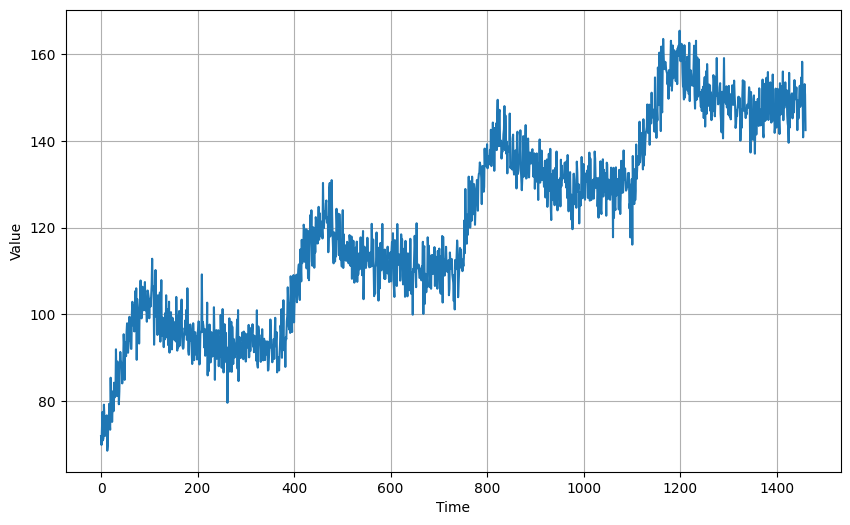

In [20]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 70
amplitude = 30
slope = 0.05
noise_level = 4

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

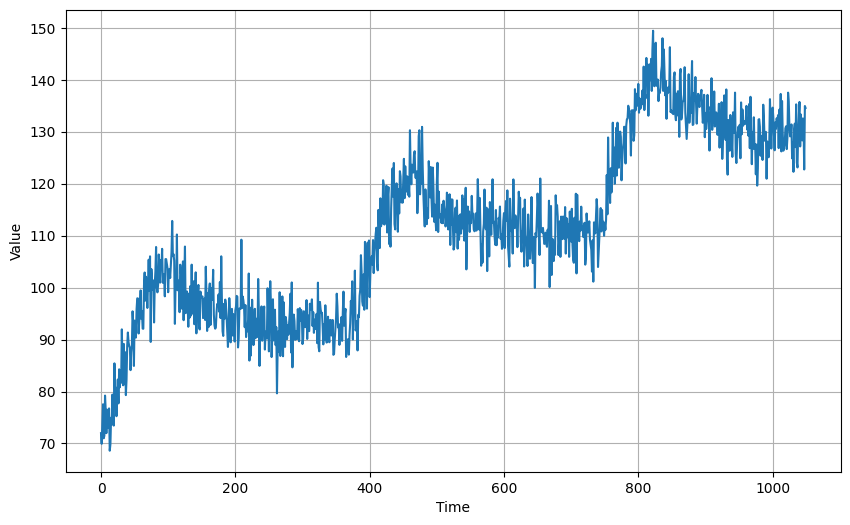

In [21]:
# Define the split time
split_time = 1050

# Get the train set
time_train = time[:split_time]
series_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
series_valid = series[split_time:]


# Plot the train set
plot_series(time_train, series_train)

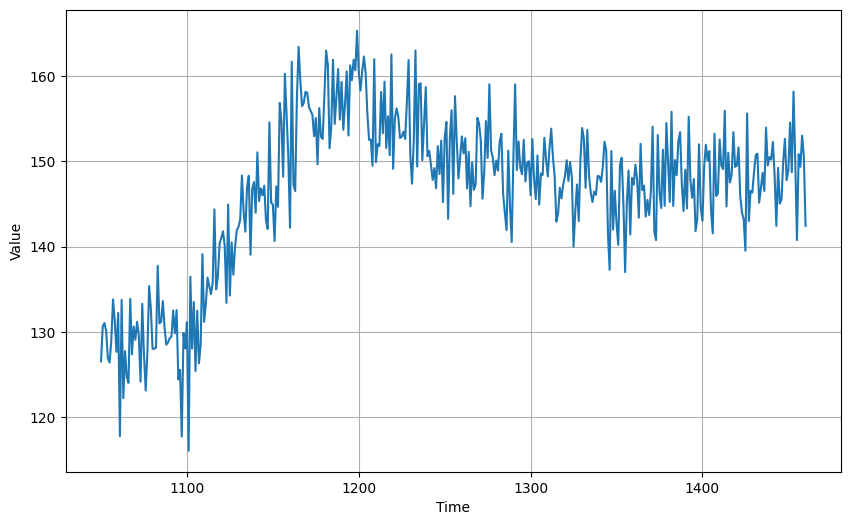

In [22]:
# Plot the validation set
plot_series(time_valid, series_valid)

### Generate features and labels

In [23]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1500


# Generate a windowed dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [24]:
# Generate the dataset windows
dataset = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size)

In [25]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


### Build and compile the model with tunable learning rate

In [34]:
# Build the model
model = keras.Sequential([
    keras.layers.Conv1D(filters=64, kernel_size=3,
                        strides=1, padding='causal',
                        activation=tf.nn.relu, input_shape=[window_size,1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 20, 64)            256       
                                                                 
 lstm_4 (LSTM)               (None, 20, 64)            33024     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
 lambda_2 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 66369 (259.25 KB)
Trainable params: 66369 (259.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
33/33 [==============================] - 8s 26ms/step - loss: 149.7948 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 1s 24ms/step - loss: 146.2730 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 1s 24ms/step - loss: 141.0951 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 2s 40ms/step - loss: 133.0200 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 1s 25ms/step - loss: 123.7498 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 1s 25ms/step - loss: 116.2064 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 1s 25ms/step - loss: 109.1976 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 1s 24ms/step - loss: 102.2782 - lr: 2.2387e-08
Epoch 9/100
33/33 [==============================] - 1s 25ms/step - loss: 95.6165 - lr: 2.5119e-08
Epoch 10/100
33/33 [==============================] - 1s 24ms/step - loss: 89.0529 - lr: 2.8184e-08
E

(1e-08, 0.001, 0.0, 50.0)

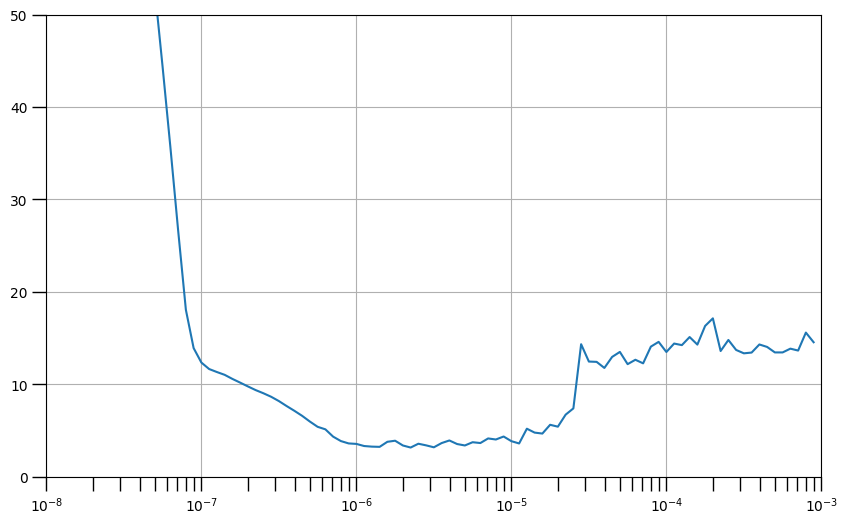

In [36]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

### Train the model with appropriate learning rate

In [37]:
# Get the index of the minimum loss value
loss_min = np.argmin(history.history['loss'])

# Get the learning rate from that position
lr = lrs[loss_min]
lr

2.23872113856834e-06

In [38]:
model.compile(loss=keras.losses.Huber(), optimizer=keras.optimizers.SGD(learning_rate=lr, momentum=0.9), metrics=['mae'])

# Train the model for 100 epochs
history = model.fit(dataset, epochs=100)

Epoch 1/100
33/33 [==============================] - 6s 41ms/step - loss: 17.6700 - mae: 18.1651
Epoch 2/100
33/33 [==============================] - 1s 37ms/step - loss: 14.7181 - mae: 15.2133
Epoch 3/100
33/33 [==============================] - 1s 25ms/step - loss: 13.3783 - mae: 13.8703
Epoch 4/100
33/33 [==============================] - 1s 26ms/step - loss: 13.1153 - mae: 13.6069
Epoch 5/100
33/33 [==============================] - 1s 26ms/step - loss: 13.0838 - mae: 13.5730
Epoch 6/100
33/33 [==============================] - 1s 27ms/step - loss: 13.0885 - mae: 13.5786
Epoch 7/100
33/33 [==============================] - 1s 27ms/step - loss: 13.0863 - mae: 13.5762
Epoch 8/100
33/33 [==============================] - 1s 25ms/step - loss: 13.0825 - mae: 13.5716
Epoch 9/100
33/33 [==============================] - 1s 26ms/step - loss: 13.0859 - mae: 13.5755
Epoch 10/100
33/33 [==============================] - 1s 26ms/step - loss: 13.0863 - mae: 13.5768
Epoch 11/100
33/33 [=========

In [39]:
# We can define a function to fast process the prediction
def model_forecast(model, series, window_size, batch_size):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

13/13 [==============================] - 1s 12ms/step


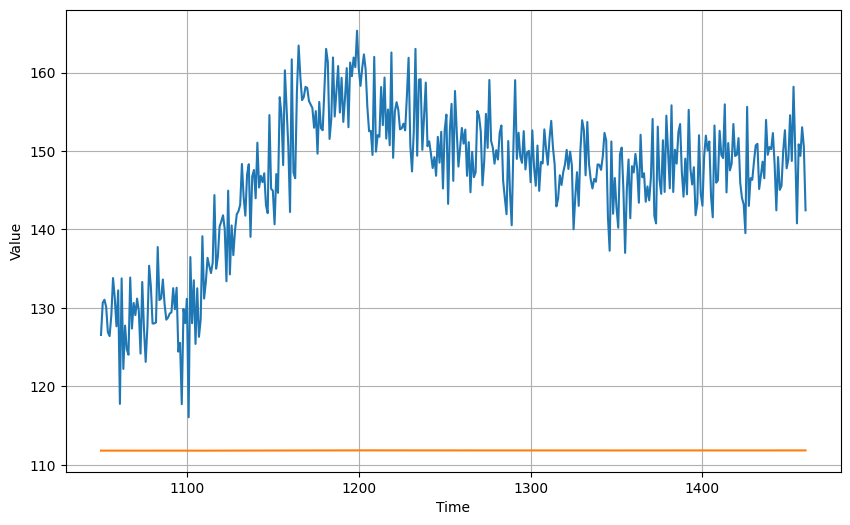

In [40]:
# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (series_valid, results))

In [41]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(series_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(series_valid, results).numpy())

1287.7856
34.672672
